In [ ]:
# Install java and PySpark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.5.1-bin-hadoop3'

In [ ]:
!echo $JAVA_HOME
!echo $SPARK_HOME

/usr/lib/jvm/java-8-openjdk-amd64
/content/spark-3.5.1-bin-hadoop3


In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("Midterm").setMaster("local")
sc = SparkContext(conf=conf)

In [ ]:
# Download baskets.csv save to /content/baskets.csv
!wget https://raw.githubusercontent.com/thnhan2/bigdata-midterm/main/baskets.csv

# Init path to csv
path_to_csv = '/content/baskets.csv'

--2024-05-11 06:03:33--  https://raw.githubusercontent.com/thnhan2/bigdata-midterm/main/baskets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1566578 (1.5M) [text/plain]
Saving to: ‘baskets.csv’

baskets.csv         100%[===================>]   1.49M  8.41MB/s    in 0.2s    

2024-05-11 06:03:33 (8.41 MB/s) - ‘baskets.csv’ saved [1566578/1566578]



# Task 1: RDD
## function f1
Input: Path to the file baskets.csv.

Processing: <br />
- Read data from the file baskets.csv.

- Find the list of distinct products.

- Sort the results in ascending order of product names.

Output: <br />
- Print the first 10 and last 10 products in the sorted list on the screen.
- Save all the results to the folder f1.

In [ ]:
import pyspark as spark

def f1(path_to_csv: str) -> None:
    rdd = sc.textFile(path_to_csv)

    # Skip the header
    header = rdd.first()
    rdd = rdd.filter(lambda row: row != header)

    # split fields
    rdd_split = rdd.map(lambda line: line.split(','))

    # Extract the itemDescription column
    products_rdd = rdd_split.map(lambda fields: fields[2])

    # Get distinct products and sort name asc
    distinct_products = products_rdd.distinct().sortBy(lambda product: product)
    print(f'Number of distinct products: {distinct_products.count()}\n')
    # first 10 products
    first_10 = distinct_products.take(10)
    print("First 10 products:")
    for product in first_10:
        print(product)

    # Last 10 products
    last_10 = distinct_products.top(10)
    last_10.sort()
    print("\nLast 10 products:")
    for product in last_10:
        print(product)

    !rm -rf /content/f1
    distinct_products.saveAsTextFile('/content/f1')


if __name__ == '__main__':
    f1(path_to_csv)

Number of distinct products: 167

First 10 products:
Instant food products
UHT-milk
abrasive cleaner
artif. sweetener
baby cosmetics
bags
baking powder
bathroom cleaner
beef
berries

Last 10 products:
turkey
vinegar
waffles
whipped/sour cream
whisky
white bread
white wine
whole milk
yogurt
zwieback


## Function f2
Input: path to file `baskets.csv`

Processing
- Find the list of distinct products adn their requency of being purchased.
- Store result in the descending order of frequency.

Output:
- Draw bar chart to visulize their frequency.
- result saved in folder`/f2`

Top 10 products and their frequencies:
+-------+------------------+-----------+
| Index |     Product      | Frequency |
+-------+------------------+-----------+
|   1   |    whole milk    |    2502   |
|   2   | other vegetables |    1898   |
|   3   |    rolls/buns    |    1716   |
|   4   |       soda       |    1514   |
|   5   |      yogurt      |    1334   |
|   6   | root vegetables  |    1071   |
|   7   |  tropical fruit  |    1032   |
|   8   |  bottled water   |    933    |
|   9   |     sausage      |    924    |
|   10  |   citrus fruit   |    812    |
+-------+------------------+-----------+


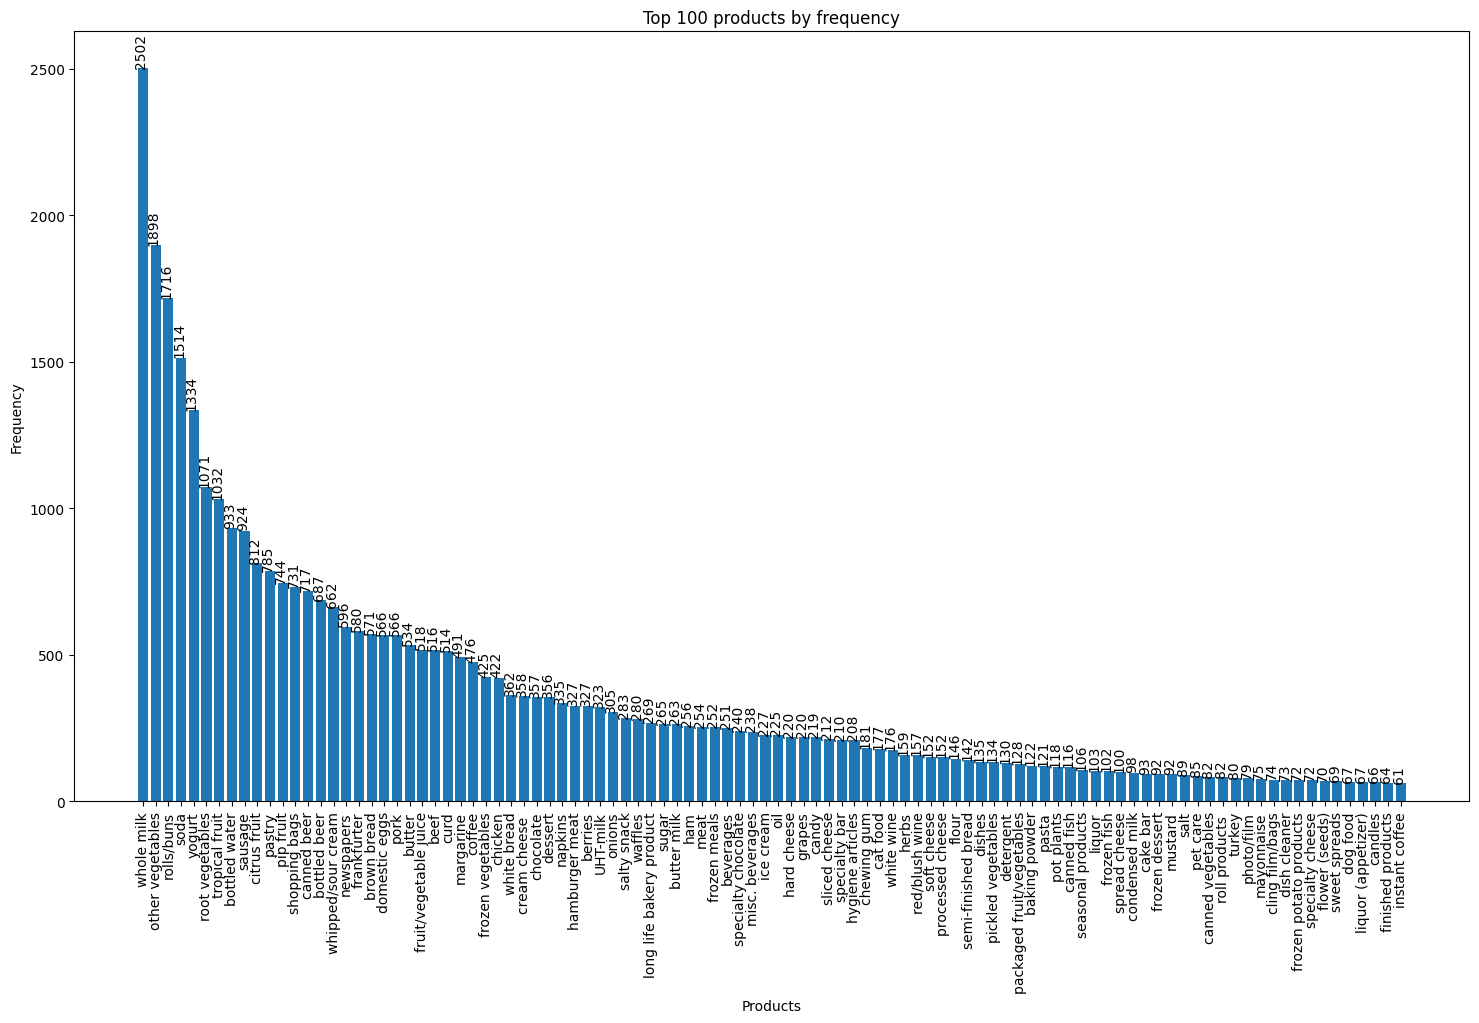

In [ ]:
from prettytable import PrettyTable
import matplotlib.pyplot as plt

def f2(path_to_csv: str) -> None:
    rdd = sc.textFile(path_to_csv)

    # Skip the header
    header = rdd.first()
    rdd = rdd.filter(lambda row: row != header)

    product_rdd = rdd.map(lambda line: line.split(',')[2])
    # Calculate the frequency of each product
    product_counts = product_rdd.countByValue()

    # Sort the products by frequency in descending order
    sorted_product_counts = sorted(product_counts.items(), key=lambda x: x[1], reverse=True)

    # Save all products and their frequencies to the '/content/f2' directory
    !rm -rf /content/f2
    sc.parallelize(sorted_product_counts).saveAsTextFile('/content/f2')

    table = PrettyTable(['Index', 'Product', 'Frequency'])

    # Print top 10 products have highest frequency
    index = 1
    for product, frequency in sorted_product_counts:
        table.add_row([index, product, frequency])
        index += 1
        if index == 11:
            break

    print('Top 10 products and their frequencies:')
    print(table)

    # Get the top 100 products by frequency
    top_100_products = sorted_product_counts[:100]

    # Prepare data for the bar chart
    products, frequencies = zip(*top_100_products)
    plt.rcParams['figure.figsize'] = (18, 10)
    bars = plt.bar(products, frequencies)
    plt.xlabel('Products')
    plt.ylabel('Frequency')
    plt.title('Top 100 products by frequency')
    plt.xticks(rotation=90)
    for bar, frequency in zip(bars, frequencies):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.5, str(frequency), ha='center', va='bottom', rotation=90)
    plt.show()

if __name__ == '__main__':
    f2(path_to_csv)


## Function f3
Input: <br />
Path to baskets.csv

Processing: <br />
Read data, calculate the number of unique baskets per member, sort members by basket count in descending order, and select the top 100 members.

Output:
- A printed and saved list of members and their basket counts
- Draw bar chart visualizing the top 100 members' basket counts.

+---------------+-------------------+
| Member_number | Number of Baskets |
+---------------+-------------------+
|      1379     |         11        |
|      3737     |         11        |
|      2271     |         11        |
|      4338     |         11        |
|      2193     |         11        |
|      4376     |         10        |
|      1052     |         10        |
|      1574     |         10        |
|      1275     |         10        |
|      1908     |         10        |
+---------------+-------------------+


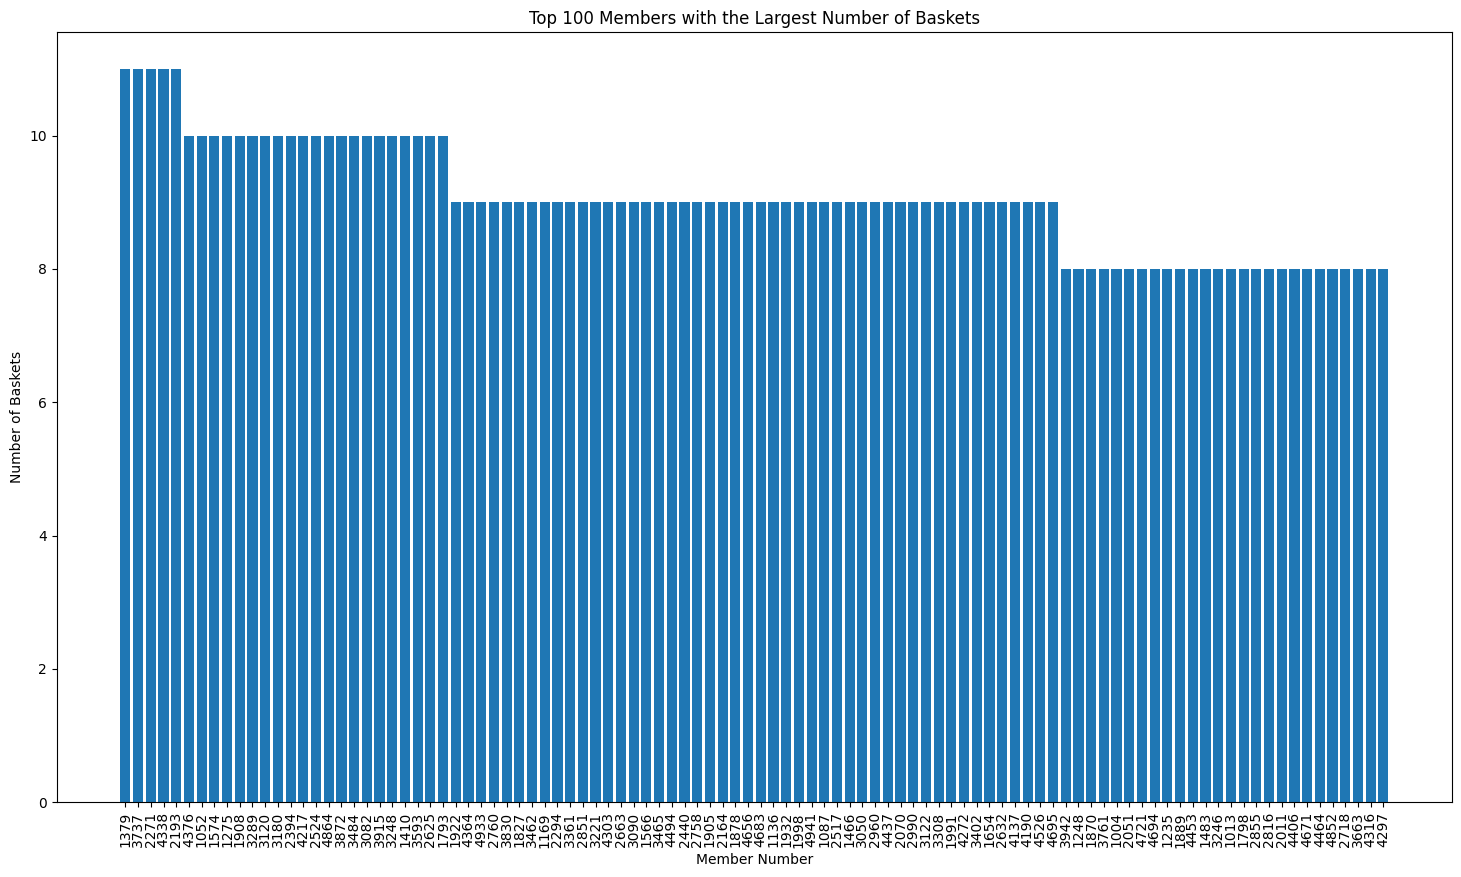

In [ ]:
import matplotlib.pyplot as plt

def f3(path_to_csv):
    data = sc.textFile(path_to_csv)

    # Remove header
    header = data.first()
    data = data.filter(lambda line: line != header)

    # Create a tuple (Member_number, Date, itemDescription)
    data = data.map(lambda line: line.split(",")).map(lambda tokens: (tokens[0], tokens[1], tokens[2]))

    # Create a basket for each member in a date
    baskets = data.map(lambda x: ((x[0], x[1]), [x[2]])).reduceByKey(lambda a, b: a + b)

    # Count the number of baskets for each member
    basket_counts = baskets.map(lambda x: (x[0][0], 1)).reduceByKey(lambda a, b: a + b)

    # Sort in the descending order of number of baskets and select top 100 members
    top_100_members = basket_counts.sortBy(lambda x: -x[1])
    !rm -rf /content/f3
    top_100_members.map(lambda x: ",".join(map(str, x))).coalesce(1).saveAsTextFile('/content/f3')
    top_100_members = top_100_members.take(100)

    # Draw a bar chart
    members = [x[0] for x in top_100_members]
    counts = [x[1] for x in top_100_members]
    table_member_baskets = PrettyTable(['Member_number', 'Number of Baskets'])
    index = 0
    # print first 10 member an products highest number of baskets
    for x, y in zip(members, counts):
        index+=1
        if index == 11:
            break
        table_member_baskets.add_row([x, y])

    print(table_member_baskets)

    plt.bar(members, counts,align='center')
    plt.xticks(range(len(members)), members, rotation=90)
    plt.xlabel('Member Number')
    plt.ylabel('Number of Baskets')
    plt.title('Top 100 Members with the Largest Number of Baskets')
    plt.show()

if __name__=="__main__":
    f3(path_to_csv)

## Function f4
Input:
File: baskets.csv <br />

Processing:
- Load data
- Find Member with Most Distinct Products:
 + Group purchases by member ID.
 + For each member group, calculate the number of unique products.
 + Identify the member ID with the maximum number of distinct products.
- Find Most Popular Product:
 + Aggregate product purchases across all member groups.
 + Calculate the number of times each product is bought.
 + Determine the product with the highest purchase count.

Output:

Member: member_number who bought the largest number of distinct products.

Product: Print the name of the product bought by the most members

In [ ]:
from prettytable import PrettyTable

def f4(path_to_csv: str) -> None:
    rdd = sc.textFile(path_to_csv)

    # Member_number and itemDescription
    header = rdd.first()
    rdd = rdd.filter(lambda line: line != header)
    pairs_member_item = rdd.map(lambda line: (line.split(',')[0], line.split(',')[2]))

    # find member that bought the largest number of distinct products.
    member_counts = pairs_member_item.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b)

    max_member = member_counts.max(lambda x: x[1])

    print(f'Member_number {max_member[0]} Purchased {max_member[1]} Different products.')
    table1 = PrettyTable(['Member_number', 'Number Different product'])

    sorted_member_counts = member_counts.sortBy(lambda x: x[1], ascending=False)
    top10 = sorted_member_counts.take(10)
    for item in top10:
        table1.add_row(item)
    print(table1)



    # 2
    product_member_pairs = rdd.map(lambda x: (x.split(',')[2], x.split(',')[0]))

    # group product by name
    product_groups = product_member_pairs.groupByKey()

    # process member duplicate and count.
    product_counts = product_groups.mapValues(lambda x: len(set(x)))

    table2 = PrettyTable(['itemDescription','Amount'])
    sorted_product_counts = product_counts.sortBy(lambda x: x[1], ascending=False)
    top10product = sorted_product_counts.take(10)
    for item in top10product:
        table2.add_row(item)
    print(table2)

    # sort by number descending
    sorted_counts = product_counts.sortBy(lambda x: -x[1])

    # product purchased by highest different member.
    top_product = sorted_counts.take(1)[0]

    print("Product purchased by highest different member:", top_product[0])
    print("Total member buy it:", top_product[1])



table = PrettyTable(["Member_number", "NumberOfBaskets"])
if __name__=='__main__':

    f4(path_to_csv)

Member_number 3180 Purchased 36 Different products.
+---------------+--------------------------+
| Member_number | Number Different product |
+---------------+--------------------------+
|      3180     |            36            |
|      2051     |            33            |
|      3737     |            33            |
|      3050     |            33            |
|      2271     |            31            |
|      3915     |            31            |
|      2625     |            31            |
|      2433     |            31            |
|      3872     |            30            |
|      2851     |            29            |
+---------------+--------------------------+
+------------------+--------+
| itemDescription  | Amount |
+------------------+--------+
|    whole milk    |  1786  |
| other vegetables |  1468  |
|    rolls/buns    |  1363  |
|       soda       |  1222  |
|      yogurt      |  1103  |
|  tropical fruit  |  911   |
| root vegetables  |  899   |
|  bottled water  

## Task 2

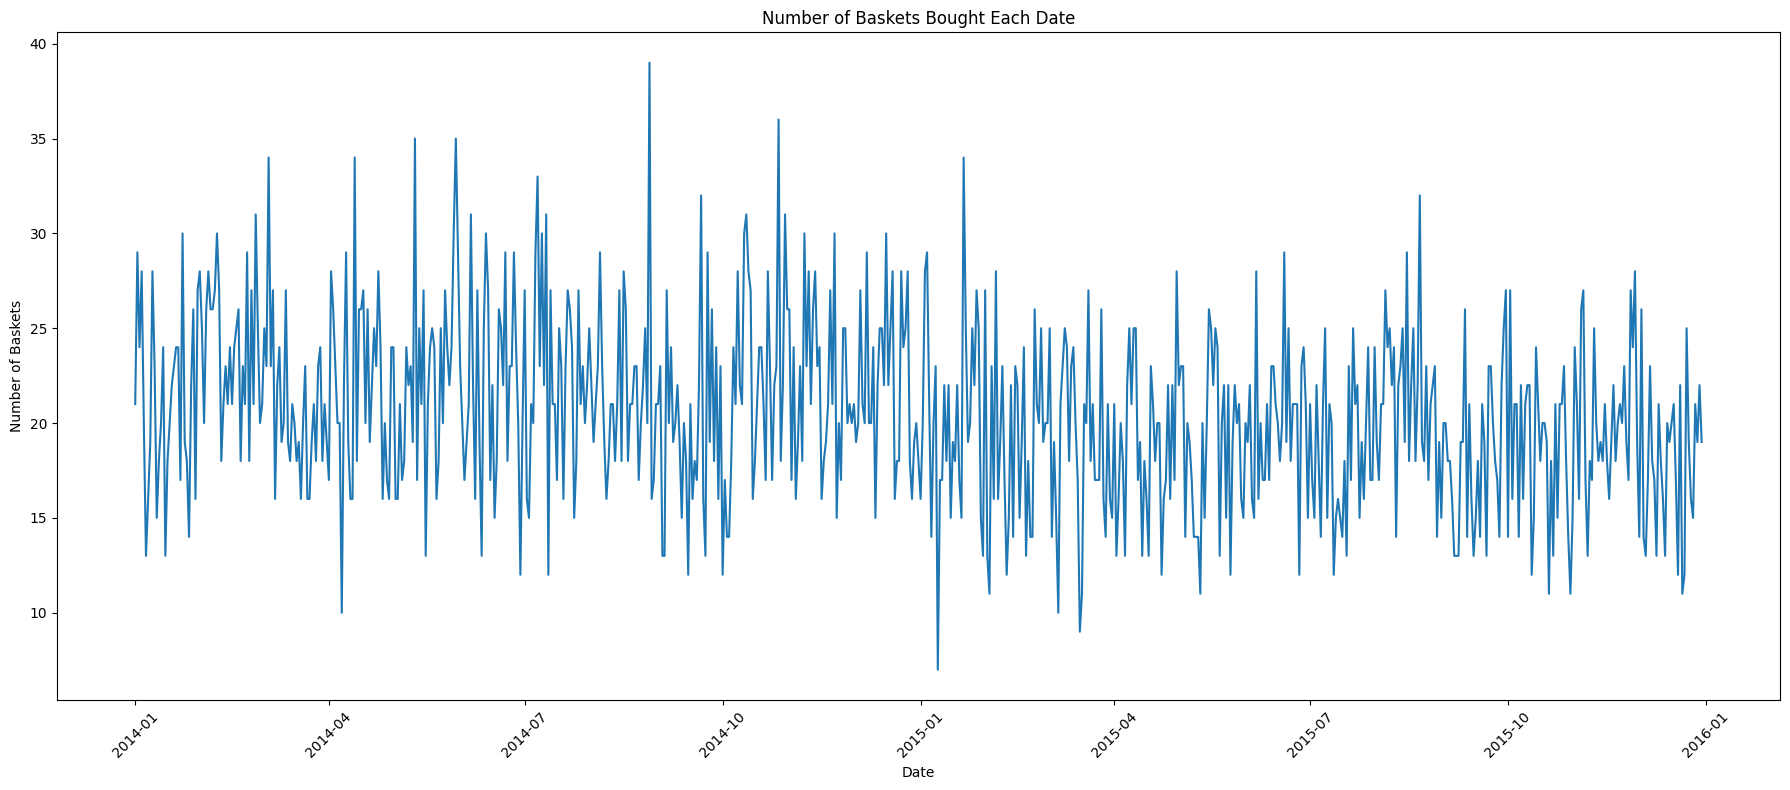

In [ ]:
# Task 2
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, collect_set, to_date, lit, concat_ws
import matplotlib.pyplot as plt

# Create a SparkSession
spark = SparkSession.builder.appName("Task 2").getOrCreate()

# Load the CSV file into a DataFrame
df = spark.read.csv(path_to_csv, header=True, inferSchema=True)

# Convert date column from string to date format
df = df.withColumn("Date", to_date(lit(df["Date"]), "d/M/yyyy"))

# Find the list of baskets
transactions_df = df.groupBy("Member_number", "Date") \
                .agg(collect_set("itemDescription").alias("Basket")) \
                .orderBy("Date")

# Convert the array of strings into a single string representation
transactions_df = transactions_df.withColumn("Basket", concat_ws(", ", "Basket"))

# Count the number of baskets bought on each date
transactions_count_df = transactions_df.groupBy("Date").agg(count("*").alias("BasketCount")).orderBy("Date")

# Convert Spark DataFrame to Pandas DataFrame for visualization
transactions_count_pandas_df = transactions_count_df.toPandas()

# Visualize the number of baskets bought on each date using a line chart
plt.rcParams['figure.figsize'] = (18, 8)
plt.plot(transactions_count_pandas_df["Date"], transactions_count_pandas_df["BasketCount"])
plt.xlabel("Date")
plt.ylabel("Number of Baskets")
plt.title("Number of Baskets Bought Each Date")
plt.xticks(rotation=45)
plt.tight_layout()

# Save the visualization as an image file
plt.savefig("basket_analysis.png")

# Save the resulting baskets into the "baskets" folder
transactions_df.select("Member_number", "Date", "Basket").write.csv("baskets", mode="overwrite", header=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Task 3

**Algorithm**

**Pass 1:**
- FOR (each basket):
  - FOR (each item in the basket):
    - Add 1 to item's count
  - FOR (each pair of items):
    - Hash the pair to a bucket
    - Add 1 to the count for that bucket

**Pass 2:**
- Count all pairs {i, j} that meet the conditions for being a candidate pair:
  1. Both i and j are frequent items
  2. The pair {i, j} hashes to a bucket whose bit in the bit vector is 1


In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import explode, split, udf, col
from itertools import combinations
from pyspark.sql.types import StringType, IntegerType, ArrayType

class PCY:
  def __init__(self, path_to_baskets, support_threshold, confidence_threshold):
    self.spark = SparkSession.builder.appName("Task 3").getOrCreate()
    self.path_to_baskets = path_to_baskets
    self.support_threshold = support_threshold
    self.confidence_threshold = confidence_threshold

  def run(self):
    # Load baskets
    transactions_df = self.spark.read.csv(self.path_to_baskets, header=True, inferSchema=True)
    transactions_df = transactions_df.withColumn("Basket", split(transactions_df["Basket"], ",\s*"))
    transactions_df.printSchema()
    transactions_df.show(truncate=0)

    # Split basket column
    basket_df = transactions_df.select("Basket")

    # Explode baskets into individual items to count frequency
    items_df = basket_df.select(explode(basket_df.Basket).alias("Items"))

    # Count the frequency each item and remove the candidate set having length 1
    item_freq_df  = items_df.groupBy("Items").count().withColumnRenamed("count", "Frequency").orderBy(col("Frequency").desc()).filter("Frequency > 1")
    print("Items frequency:")
    item_freq_df.show(truncate=0)

    # Create all the possible pairs
    @udf(ArrayType(ArrayType(StringType())))
    def create_unique_combinations(items):
      pairs = set()  # Sử dụng set để lưu trữ các cặp mặt hàng duy nhất
      for i in range(len(items)):
          for j in range(i + 1, len(items)):
            if items[i] != items[j]:
              pair = sorted([items[i], items[j]])  # Sắp xếp để đảm bảo các cặp có thứ tự nhất quán
              print(pair)
              if len(pair) > 1:
                pairs.add(tuple(pair))  # Thêm cặp vào set, hàm tuple() để chuyển đổi cặp mặt hàng từ dạng list sang dạng tuple, vì chỉ có các tuple mới có thể được thêm vào set
      pairs = {pair for pair in pairs if len(pair) > 1}
      return [list(pair) for pair in pairs] #chuyển đổi các tuple trong set thành các list

    # Apply the UDF to the 'Basket' column
    baskets_df_with_unique_combinations = transactions_df.withColumn('UniqueCombination', create_unique_combinations(col('Basket')))

    # Frequency of pairs
    pairs_frequencies = (baskets_df_with_unique_combinations
                        .withColumn("Pairs", explode("UniqueCombination"))
                        .groupBy("Basket", "Pairs")
                        .agg(F.count("*").alias("Frequency"))
                        .groupBy("Pairs")
                        .agg(F.sum("Frequency").alias("Frequency"))
                        .orderBy(F.desc("Frequency")))
    print("Pair frequency:")
    pairs_frequencies.show(truncate=0)

    # Filter pairs by support threshold
    total_baskets = transactions_df.count()
    support_threshold_count = int(self.support_threshold * total_baskets)
    filter_pairs = pairs_frequencies.filter(f"Frequency >= {self.support_threshold * support_threshold_count}")
    print("Filter pairs with support threhold")
    filter_pairs.show(truncate=0)

    # Function to calculate the hash value
    def calculate_hash(pair_list):
      if pair_list is None or len(pair_list) == 0:
          return 0
      pair_tuple = tuple(pair_list)
      return hash(pair_tuple)

    # Create a UDF from the function
    calculate_hash_udf = udf(calculate_hash, IntegerType())

    # Apply the UDF to the 'Pairs' column
    hash_df = filter_pairs.withColumn('Buck_no', calculate_hash_udf(col('Pairs')))
    buck_no_df = hash_df.select("Pairs", "Buck_no")
    buck_no_df.show(truncate=0)

    # Prepare candidate set table
    candidate_set_table = hash_df.withColumn("Bit vector", F.when(hash_df["Frequency"] >= self.support_threshold * support_threshold_count, 1).otherwise(0)) # Dòng này tạo một cột mới trong DataFrame hash_df với tên là Bit vector. Nếu tần suất của cặp ứng viên lớn hơn hoặc bằng ngưỡng hỗ trợ, giá trị của cột này sẽ là 1; ngược lại, nó sẽ là 0
    candidate_set_table = candidate_set_table.withColumn("Bucket number", col("Buck_no")) #giá trị của nó được lấy từ cột "Buck_no"
    candidate_set_table = candidate_set_table.withColumnRenamed("Frequency", "Highest Support Count")
    candidate_set_table = candidate_set_table.withColumnRenamed("Pairs", "Pairs")
    candidate_set_table = candidate_set_table.withColumn("Candidate set", F.when(candidate_set_table["Bit vector"] == 1, candidate_set_table["Pairs"]).otherwise(None))
    candidate_set_table = candidate_set_table.select("Bit vector", "Bucket number", "Highest Support Count", "Pairs", "Candidate set").orderBy("Bit vector") # chọn các cột cần thiết và sắp xếp dữ liệu dựa trên cột Bit vector

    # Show the candidate set table
    print("Candidate set table:")
    candidate_set_table.show(truncate=False)

    # Save frequent pairs
    candidate_set = candidate_set_table.select("Candidate set", "Highest Support Count").withColumn("Candidate set", concat_ws(", ", "Candidate set"))
    candidate_set.write.csv("pcy_frequent_pairs.csv", mode="overwrite", header=True)
    print("PCY algorithm executed and results saved")

pcy = PCY("baskets", support_threshold=0.1, confidence_threshold=0.5)
pcy.run()

root
 |-- Member_number: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Basket: array (nullable = true)
 |    |-- element: string (containsNull = false)

+-------------+----------+-------------------------------------------------+
|Member_number|Date      |Basket                                           |
+-------------+----------+-------------------------------------------------+
|1249         |2014-01-01|[citrus fruit, coffee]                           |
|1381         |2014-01-01|[curd, soda]                                     |
|1440         |2014-01-01|[yogurt, other vegetables]                       |
|1659         |2014-01-01|[specialty chocolate, frozen vegetables]         |
|1789         |2014-01-01|[candles, hamburger meat]                        |
|1922         |2014-01-01|[tropical fruit, other vegetables]               |
|2226         |2014-01-01|[sausage, bottled water]                         |
|2237         |2014-01-01|[Instant food products, bottled 